# lesson 2

主要内容是读写空间数据，以及如何在Python中使用Geopandas模块和一些有用的数据管理功能处理投影。

## 目标

- 读写Shapefile数据
- 在GeoDataFrame下创建geometries
- 改变数据坐标参考系统

## Geopandas简介

使用Geopandas可以轻松地在python中处理地理空间数据。geopandas将pandas的数据分析库和其他像shapely和fiona之类的管理空间数据的库结合起来。

geopandas中最主要的数据结构是GeoSeries和GeoDataFrame，他们扩展了pandas的Series和DataFrames。也就是说，可以应用pandas的技巧到geopandas的数据结构上。

GeoDataFrames和DataFrames的最主要的区别是一个geodataframe需要包含一列geometries。这列geometry是一个geoseries，它每行都有geometries数据。

使用geopandas的一些基本步骤：

- 管理文件路径
- 读取shapefile
- 几何计算
- 写入shapefile
- 分组，切分空间数据到多图层

### 输入数据

因为该教程是芬兰的老师做的，所以这里给的例子也是芬兰的地理数据库。

### 下载数据

在jupyter lab下打开一个终端，进入到本文件根目录下，执行：

```
$ wget https://github.com/AutoGIS/data/raw/master/L2_data.zip
$ unzip L2_data.zip
$ ls L2_data
```

如果是windows系统，可以[安装wget](https://builtvisible.com/download-your-website-with-wget/)并配置路径，也可以直接去上述地址手动下载，然后解压。

注意，shapefile包括许多文件，比如.dbf文件包含属性信息，.prj文件包含坐标系统的信息。

### 管理文件路径

python的内置os模块有许多可用来和操作系统交互的函数。其中，最常用的就是操作文件路径的os.path模块。

In [1]:
import os

# Define path to folder
input_folder = r"L2_data/NLS/2018/L4/L41/L4132R.shp"

# Join folder path and filename
fp = os.path.join(input_folder, "m_L4132R_p.shp")

# Print out the full file path
print(fp)

L2_data/NLS/2018/L4/L41/L4132R.shp\m_L4132R_p.shp


### 读取shapefile

典型的分析数据的第一步就是读取数据到python中。GIS数据格式有很多，比如Shapefile，GeoJSON，KML和GPKGDENG是最常用的矢量数据格式。Geopandas能够读取所有这些类型的数据。

在geopandas中，我们使用一个泛型函数.from_file()来读取不同类型的数据，geopandas会自动在后台使用fiona.open()来读取数据。

In [2]:
import geopandas as gpd

# Read file using gpd.read_file()
data = gpd.read_file(fp)

type(data)

geopandas.geodataframe.GeoDataFrame

In [3]:
print(data.head())

  TEKSTI  RYHMA  LUOKKA  TASTAR  KORTAR  KORARV  KULKUTAPA    KOHDEOSO  \
0   None     64   32421    5000       0     0.0          0  1812247077   
1   None     64   32421    5000       0     0.0          0  1718796908   
2   None     64   32421   20000       0     0.0          0   411167695   
3   None     64   32421   20000       0     0.0          0   411173768   
4   None     64   32421   20000       0     0.0          0   411173698   

   AINLAHDE SYNTYHETKI  ... KARTOGLK  ALUEJAKOON  VERSUH  SUUNTA  SIIRT_DX  \
0         1   20180125  ...        0           0       0       0         0   
1         1   20180120  ...        0           0       0       0         0   
2         1   20180120  ...        0           0       0       0         0   
3         1   20180120  ...        0           0       0       0         0   
4         1   20180120  ...        0           0       0       0         0   

   SIIRT_DY  KORKEUS  ATTR2  ATTR3  \
0         0      0.0      0      0   
1         

In [4]:
data.columns

Index(['TEKSTI', 'RYHMA', 'LUOKKA', 'TASTAR', 'KORTAR', 'KORARV', 'KULKUTAPA',
       'KOHDEOSO', 'AINLAHDE', 'SYNTYHETKI', 'KUOLHETKI', 'KARTOGLK',
       'ALUEJAKOON', 'VERSUH', 'SUUNTA', 'SIIRT_DX', 'SIIRT_DY', 'KORKEUS',
       'ATTR2', 'ATTR3', 'geometry'],
      dtype='object')

In [5]:
# rename the columns
data = data[['RYHMA', 'LUOKKA',  'geometry']]
colnames = {'RYHMA':'GROUP', 'LUOKKA':'CLASS'}
data.rename(columns=colnames, inplace=True)
data.columns

Index(['GROUP', 'CLASS', 'geometry'], dtype='object')

In [6]:
print("Number of rows", len(data['CLASS']))
print("Number of classes", data['CLASS'].nunique())
print("Number of groups", data['GROUP'].nunique())

Number of rows 4311
Number of classes 20
Number of groups 1


习惯在map上探索数据是极好的，从GeoDataFrame构建一个map是很容易的，可以使用geopandas的.plot函数基于数据的geometries构建map。Geopandas会使用matplotlib构图。

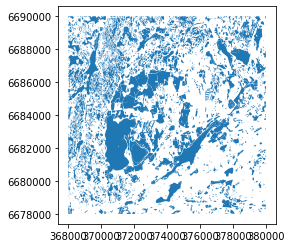

In [8]:
%matplotlib inline
data.plot()

geopandas默认将地图充满整个数据展示面板。

### Geopandas中的Geometries

geopandas利用了shapely中的gometric对象，geometries存储在称作geometry的列中，geometry是默认的列名，在geopandas中存储geometric信息。

In [9]:
print(data['geometry'].head())

0    POLYGON ((379394.248 6689991.936, 379389.790 6...
1    POLYGON ((378980.811 6689359.377, 378983.401 6...
2    POLYGON ((378804.766 6689256.471, 378817.107 6...
3    POLYGON ((379229.695 6685025.111, 379233.366 6...
4    POLYGON ((379825.199 6685096.247, 379829.651 6...
Name: geometry, dtype: geometry


如上结果所示，geometry列中包含shapely的Polygon对象。因为空间数据是一shapely对象的形式存储的，因此在geopandas中处理geometries是可以使用shapely模块的所有功能的。

In [10]:
print("Polygon:", data.at[0, "geometry"])
print("Area:", round(data.at[0, "geometry"].area,0), "square meters")

Polygon: POLYGON ((379394.248 6689991.936, 379389.79 6690000, 379408.646 6690000, 379394.248 6689991.936))
Area: 76.0 square meters


In [11]:
# Iterate over rows and print the area of a Polygon
for index, row in data[0:5].iterrows():

    # Get the area from the shapely-object stored in the geometry-column
    poly_area = row['geometry'].area

    # Print info
    print("Polygon area at index {index} is: {area:.2f} m^2".format(index=index, area=poly_area))

Polygon area at index 0 is: 76.03 m^2
Polygon area at index 1 is: 2652.05 m^2
Polygon area at index 2 is: 3185.65 m^2
Polygon area at index 3 is: 13075.17 m^2
Polygon area at index 4 is: 3980.68 m^2


如上代码所示，在geopandas中pandas的所有功能都是可以直接使用的，而且不需要再额外调用pandas，因为geopandas就是pandas的一个扩展。对于面积，geopandas还提供了额外的计算函数：

In [12]:
data.area.head()

0       76.027392
1     2652.054186
2     3185.649995
3    13075.165279
4     3980.682621
dtype: float64

In [13]:
# Create a new column called 'area' and assign the area of the Polygons into it
data['area'] = data.area
data['area'].head()

0       76.027392
1     2652.054186
2     3185.649995
3    13075.165279
4     3980.682621
Name: area, dtype: float64

In [14]:
# Maximum area
max_area = data['area'].max()
# Minimum area
min_area = data['area'].min()
# Mean area
mean_area = data['area'].mean()
print("Max area: {maximum} square meters".format(maximum=round(max_area, 0)))
print("Min area: {minimum} square meters".format(minimum=round(min_area, 0)))
print("Mean area: {mean} square meters".format(mean=round(mean_area, 0)))

Max area: 4084558.0 square meters
Min area: 1.0 square meters
Mean area: 11522.0 square meters


### 写入shapefile

到处GeoDataFrames到各种数据类型使用的是gpd.to_file()函数。

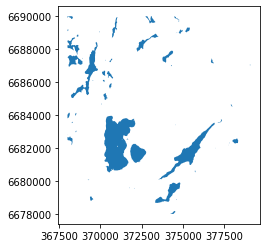

In [15]:
# Select a class
selection = data.loc[data["CLASS"]==36200]
selection.plot()
# Create a output path for the data
output_folder = r"L2_data/"
output_fp = os.path.join(output_folder, "Class_36200.shp")
# Write those rows into a new file (the default output file format is Shapefile)
selection.to_file(output_fp)

### Geodataframe分组

在pandas和geopandas中一个很有用的函数就是.groupby()，它可以根据被选择的列的值对数据进行分组。

In [16]:
data.head()

,GROUP,CLASS,geometry,area
0,64,32421,"POLYGON ((379394.248 6689991.936, 379389.790 6...",76.027392
1,64,32421,"POLYGON ((378980.811 6689359.377, 378983.401 6...",2652.054186
2,64,32421,"POLYGON ((378804.766 6689256.471, 378817.107 6...",3185.649995
3,64,32421,"POLYGON ((379229.695 6685025.111, 379233.366 6...",13075.165279
4,64,32421,"POLYGON ((379825.199 6685096.247, 379829.651 6...",3980.682621


In [18]:
# Print all unique values in the column
print(data['CLASS'].unique())
# Group the data by class
grouped = data.groupby('CLASS')

# Let's see what we have
grouped

[32421 32200 34300 34100 34700 32500 32112 32111 32611 32612 32800 32900
 35300 35412 35411 35421 33000 33100 36200 36313]


In [19]:
grouped.groups.keys()

dict_keys([32111, 32112, 32200, 32421, 32500, 32611, 32612, 32800, 32900, 33000, 33100, 34100, 34300, 34700, 35300, 35411, 35412, 35421, 36200, 36313])

In [20]:
# Iterate over the group object
for key, group in grouped:

    # Let's check how many rows each group has:
    print('Terrain class:', key)
    print('Number of rows:', len(group), "\n")

Terrain class: 32111
Number of rows: 1 

Terrain class: 32112
Number of rows: 1 

Terrain class: 32200
Number of rows: 2 

Terrain class: 32421
Number of rows: 110 

Terrain class: 32500
Number of rows: 2 

Terrain class: 32611
Number of rows: 257 

Terrain class: 32612
Number of rows: 11 

Terrain class: 32800
Number of rows: 80 

Terrain class: 32900
Number of rows: 28 

Terrain class: 33000
Number of rows: 5 

Terrain class: 33100
Number of rows: 118 

Terrain class: 34100
Number of rows: 3005 

Terrain class: 34300
Number of rows: 1 

Terrain class: 34700
Number of rows: 3 

Terrain class: 35300
Number of rows: 134 

Terrain class: 35411
Number of rows: 35 

Terrain class: 35412
Number of rows: 449 

Terrain class: 35421
Number of rows: 5 

Terrain class: 36200
Number of rows: 56 

Terrain class: 36313
Number of rows: 8 



In [21]:
group.head()

,GROUP,CLASS,geometry,area
4303,64,36313,"POLYGON ((377127.305 6688073.257, 377116.045 6...",9619.307973
4304,64,36313,"POLYGON ((371141.897 6677999.999, 371139.757 6...",25266.167705
4305,64,36313,"POLYGON ((371498.720 6680399.799, 371497.585 6...",364.087680
4306,64,36313,"POLYGON ((375668.607 6682942.062, 375671.489 6...",2651.800270
4307,64,36313,"POLYGON ((368411.063 6679328.990, 368411.424 6...",376.503380


In [22]:
type(group)

geopandas.geodataframe.GeoDataFrame